In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date
from datetime import datetime

def fix_nan(csv_data):
    """

    :param csv_data: pd.DataFrame from test.csv
    :return: DataFrame with fixed nan in some columns and make data as datetime
    """
    csv_data["period_start_dt"] = pd.to_datetime(csv_data["period_start_dt"], format='%Y.%m.%d')
    bad_column = ["PROMO1_FLAG","PROMO2_FLAG","NUM_CONSULTANT","AUTORIZATION_FLAG"]
    for replace_name in bad_column:
        csv_data[replace_name] = csv_data[replace_name].fillna(0.0)
    csv_data = csv_data.drop(columns=['PROMO2_FLAG', 'NUM_CONSULTANT'])
    return csv_data
    
def percentile(n):
    '''Calculate n - percentile of data'''
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pctl%s' % n
    return percentile_

def lagged_features(df
                    , lags = [7, 14, 21, 28]
                    , windows = [7, 14]
                    , aggregation_methods = {'mean', 'median', percentile(10),  percentile(90)}
                    , promo_filters = [0, 1]
                    , target_var = 'demand'
                    , by_all_stores = False
                    , by_all_products = False):
    
    if len(df) == 0:
        return df
    
                
    
    # loop by filter variables and window
    for w in windows:

        # check whether filtered df in not empty
        if len(df) > 0:
            
            # lagged features calculation
            lf_df = df.set_index(['product_rk', 'store_location_rk', 'period_start_dt'])\
                 [target_var].groupby(level=['product_rk','store_location_rk']).\
                apply(lambda x: x.rolling(window=w, min_periods=1).agg(aggregation_methods))

            # provide lags tranformations
            for l in lags:
                new_names = {x: "{3}_lag{0}_wdw{1}_{2}".
                              format(l, w, x, target_var) for x in lf_df.columns }

                df = df.merge(lf_df.shift(l).reset_index().rename(columns = new_names),
                    how='left', on =['product_rk', 'store_location_rk', 'period_start_dt'] )
                
                
            if by_all_stores:
                lf_df = df.set_index(['product_rk', 'period_start_dt'])\
                    [target_var].groupby(level=['product_rk', 'period_start_dt']).median().\
                    groupby(level=['product_rk']).\
                    apply(lambda x: x.rolling(window=w, min_periods=1).agg(aggregation_methods))

                for l in lags:
                    new_names = {x: "all_stores_{3}_lag{0}_wdw{1}_{2}".
                                  format(l, w, x, target_var) for x in lf_df.columns }

                    df = df.merge(lf_df.shift(l).reset_index().rename(columns = new_names),
                        how='left', on =['product_rk', 'period_start_dt'] )
                    
            if by_all_products:
                lf_df = df.set_index(['store_location_rk', 'period_start_dt'])[target_var]\
                .groupby(level=['store_location_rk', 'period_start_dt']).median().\
                    groupby(level=['store_location_rk']).\
                    apply(lambda x: x.rolling(window=w, min_periods=1).agg(aggregation_methods))

                for l in lags:
                    new_names = {x: "all_products_{3}_lag{0}_wdw{1}_{2}".
                                  format(l, w, x, target_var) for x in lf_df.columns }

                    df = df.merge(lf_df.shift(l).reset_index().rename(columns = new_names),
                        how='left', on =['store_location_rk', 'period_start_dt'] )

    return df
    
def add_holiday_flag(df, holiday, flag_name):
    holiay_dt = datetime.strptime(holiday, '%Y-%m-%d')
    
    min_year = df['period_start_dt'].min().year
    max_year = df['period_end_dt'].max().year
    
    for year in range(min_year, max_year + 1):
        dt = datetime(year, holiay_dt.month, holiay_dt.day)
        mask = (df['period_start_dt'] < dt) & (df['period_end_dt'] >= dt)
        df.loc[mask, flag_name] = 1
        df[flag_name] = df[flag_name].fillna(0)
        df[flag_name] = df[flag_name].astype(int)
        
    return df
    
def add_all_holidays(final):
    final["no_year"] = final['period_start_dt'].map(lambda x: x.strftime("%m-%d"))
    final["period_end_dt"] = final['period_start_dt'] + pd.DateOffset(days=6)

    final = add_holiday_flag(final, "2013-02-14", flag_name="flag_14FEB")
    final = add_holiday_flag(final, "2013-02-23", flag_name="flag_23FEB")
    final = add_holiday_flag(final, "2013-03-08", flag_name="flag_8MAR")
    final = add_holiday_flag(final, "2013-05-09", flag_name="flag_9MAY")
    final = add_holiday_flag(final, "2013-09-01", flag_name="flag_1SEP")
    final = add_holiday_flag(final, "2013-01-01", flag_name="flag_NEW_YEAR")

    final = final.drop(columns=['period_end_dt'])
    final = final.drop(columns=['no_year'])
    return final

def process(csv_data):
    """

    :param csv_data: pd.DataFrame from test.csv
    :return: fixed DataFrame with one-hot for product and store
    """
    csv_data = fix_nan(csv_data)
    
    def make_column_one_hot(data, column_name):
        data = pd.merge(data, pd.get_dummies(data[column_name], prefix=column_name), left_index=True, right_index=True)
        return data
        #return data.drop(columns=column_name)

    def prepare_data(data):
        data = lagged_features(data, by_all_products=True, by_all_stores=True)
        data = make_column_one_hot(data,"product_rk")
        data = make_column_one_hot(data,"store_location_rk")
        data = add_all_holidays(data)
        return data
        
    return prepare_data(csv_data)

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from datetime import date
import scipy

In [65]:
# for colab
from google.colab import drive
drive.mount('/content/drive')
PATH = 'drive/My Drive/Иннпрак'
train = pd.read_csv(PATH + '/train.csv')
raw_data = train
raw_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,0,40369,309,2016-12-19,29.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,40370,309,2016-12-19,64.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,40372,309,2016-12-19,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,40373,309,2016-12-19,10.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,46272,309,2016-12-19,15.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
35339,35537,40370,1380,2019-12-30,NaN,0.0,0.0,1000.00,1000.0,0.0,1.0
35340,35538,40372,1380,2019-12-30,NaN,0.0,0.0,2000.00,2000.0,0.0,1.0
35341,35539,40373,1380,2019-12-30,NaN,0.0,0.0,3000.00,3000.0,0.0,1.0
35342,35540,46272,1380,2019-12-30,NaN,1.0,0.0,284.29,199.0,0.0,1.0


### Обработка данных для финального обучения
Предпологается разбиение категориальных данных (товар и магазин) в one-hot ячейки
Так же будут полезны лаговые операторы.

In [66]:
# data = fix_nan(raw_data)
final = process(raw_data)
train = final[~final.demand.isna()].copy()
test = final[final.demand.isna()].copy()
for replace_name in train.columns:
    train[replace_name] = train[replace_name].fillna(0.0)
train

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
0,0,40369,309,2016-12-19,29.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,40370,309,2016-12-19,64.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5.416393,1.5,3.505855,3.5,5.9,1.5,3.642857,3.5,3.5,3.0,3.142857,3.0,7.2,2.7,4.785714,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,40372,309,2016-12-19,32.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,11.400000,5.1,8.928571,10.5,14.3,4.8,9.857143,10.5,10.5,9.3,9.928571,10.0,14.8,6.0,10.571429,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,40373,309,2016-12-19,10.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,7.900000,3.3,5.785714,6.0,6.0,2.7,4.642857,5.0,5.6,4.8,5.142857,5.0,7.1,3.0,5.428571,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,46272,309,2016-12-19,15.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5.000000,2.4,3.857143,4.5,5.0,1.8,3.785714,4.5,4.0,3.0,3.714286,4.0,5.2,1.8,3.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35309,35507,40370,1380,2019-11-25,24.0,0.0,1000.000000,1000.000000,1.0,3.0,0.0,1.428571,1.0,2.0,0.0,0.714286,0.0,4.4,0.0,2.000000,1.0,6.4,0.0,3.714286,5.0,14.600000,4.8,9.928571,10.5,10.5,9.3,9.928571,10.0,14.8,6.0,10.571429,11.5,11.0,5.1,8.5

Добавление в train set разметку значимых календарных событий (Новый Год, 14 февраля, 23 февраля, 8 марта, 9 мая, 1 сентября)

In [67]:
def add_holiday_flag2(df, start_day, end_day, flag_name):
    nov_mar_series = pd.Series(pd.date_range(start_day, end_day))
    nov_mar_no_year = nov_mar_series.map(lambda x: x.strftime("%m-%d"))
    no_year_mask = df['no_year'].isin(nov_mar_no_year)
    df.loc[no_year_mask, flag_name] = 1
    df[flag_name] = df[flag_name].fillna(0)
    df[flag_name] = df[flag_name].astype(int)
    return df

In [68]:
train["no_year"] = train['period_start_dt'].map(lambda x: x.strftime("%m-%d"))

train = add_holiday_flag2(train, "2013-02-12", "2013-02-16", "flag_14FEB")
train = add_holiday_flag2(train, "2013-02-20", "2013-02-24", "flag_23FEB")
train = add_holiday_flag2(train, "2013-03-06", "2013-03-10", "flag_8MAR")
train = add_holiday_flag2(train, "2013-05-07", "2013-05-11", "flag_9MAY")
train = add_holiday_flag2(train, "2013-08-07", "2013-09-30", "flag_1SEP")
train = add_holiday_flag2(train, "2013-12-30", "2013-12-31", "flag_NEW_YEAR")
train = add_holiday_flag2(train, "2013-01-01", "2013-01-03", "flag_NEW_YEAR")

train = train.drop(columns=['no_year'])

In [69]:
test["no_year"] = test['period_start_dt'].map(lambda x: x.strftime("%m-%d"))

test = add_holiday_flag2(test, "2013-02-12", "2013-02-16", "flag_14FEB")
test = add_holiday_flag2(test, "2013-02-20", "2013-02-24", "flag_23FEB")
test = add_holiday_flag2(test, "2013-03-06", "2013-03-10", "flag_8MAR")
test = add_holiday_flag2(test, "2013-05-07", "2013-05-11", "flag_9MAY")
test = add_holiday_flag2(test, "2013-08-07", "2013-09-30", "flag_1SEP")
test = add_holiday_flag2(test, "2013-12-30", "2013-12-31", "flag_NEW_YEAR")
test = add_holiday_flag2(test, "2013-01-01", "2013-01-03", "flag_NEW_YEAR")

test = test.drop(columns=['no_year'])

In [70]:
# np.unique(final[final.flag_NEW_YEAR == 1]['period_start_dt'].dt.strftime('%m-%d')).tolist()
train = train.set_index('Unnamed: 0')
train

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,40369,309,2016-12-19,29.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40370,309,2016-12-19,64.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5.416393,1.5,3.505855,3.5,5.9,1.5,3.642857,3.5,3.5,3.0,3.142857,3.0,7.2,2.7,4.785714,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40372,309,2016-12-19,32.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,11.400000,5.1,8.928571,10.5,14.3,4.8,9.857143,10.5,10.5,9.3,9.928571,10.0,14.8,6.0,10.571429,11.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40373,309,2016-12-19,10.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,7.900000,3.3,5.785714,6.0,6.0,2.7,4.642857,5.0,5.6,4.8,5.142857,5.0,7.1,3.0,5.428571,6.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,46272,309,2016-12-19,15.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,5.000000,2.4,3.857143,4.5,5.0,1.8,3.785714,4.5,4.0,3.0,3.714286,4.0,5.2,1.8,3.500000,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35507,40370,1380,2019-11-25,24.0,0.0,1000.000000,1000.000000,1.0,3.0,0.0,1.428571,1.0,2.0,0.0,0.714286,0.0,4.4,0.0

In [71]:
# np.unique(final[final.flag_NEW_YEAR == 1]['period_start_dt'].dt.strftime('%m-%d')).tolist()
test = test.set_index('Unnamed: 0')
test

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
908,40369,317,2019-12-02,NaN,0.0,500.00,500.0,1.0,6.033333,2.38,4.138095,3.966667,5.400000,0.0,2.285714,2.000000,3.800000,0.0,2.142857,3.000000,5.80,0.0,3.000000,3.000000,6.824590,0.0,3.648712,4.0,3.500000,2.800000,3.071429,3.0,6.0,1.8,4.000000,4.5,5.8,2.1,4.101874,4.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
909,40370,317,2019-12-02,NaN,0.0,1000.00,1000.0,1.0,6.600000,0.00,3.142857,3.000000,6.033333,0.0,3.571429,3.966667,3.200000,0.0,1.428571,1.000000,4.20,0.0,2.285714,3.000000,14.600000,0.0,8.785714,10.5,10.500000,8.600000,9.714286,10.0,13.6,5.7,9.928571,10.5,12.2,5.1,9.000000,10.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
910,40372,317,2019-12-02,NaN,0.0,2000.00,2000.0,1.0,16.000000,3.00,10.142857,11.000000,5.800000,0.0,2.857143,3.000000,6.033333,0.0,3.290476,3.966667,3.20,0.0,1.142857,0.000000,7.000000,0.0,4.500000,6.0,5.000000,4.500000,4.857143,5.0,7.1,3.0,5.428571,6.0,6.2,2.4,4.357143,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
911,40373,317,2019-12-02,NaN,0.0,3000.00,3000.0,1.0,6.000000,1.20,4.000000,5.000000,14.000000,3.0,8.714286,9.000000,5.200000,0.0,2.142857,1.000000,9.88,0.0,4.295238,3.966667,5.000000,0.0,3.071429,4.0,5.000000,3.600000,4.142857,4.0,5.2,1.8,3.500000,4.0,4.0,1.8,2.928571,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
912,46272,317,2019-12-02,NaN,1.0,284.29,199.0,1.0,4.400000,1.20,2.857143,3.000000,6.400000,1.2,4.142857,5.000000,14.000000,0.0,7.571429,9.000000,7.40,0.0,2.714286,1.000000,2.000000,0.0,1.285714,2.0,3.500000,1.500000,2.500000,2.5,5.7,2.3,4.357143,5.0,4.0,1.5,2.642857,2.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [11]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.graph_objects as go
from prettytable import PrettyTable

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

In [12]:
train.columns

Index(['product_rk', 'store_location_rk', 'period_start_dt', 'demand',
       'PROMO1_FLAG', 'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'AUTORIZATION_FLAG',
       'demand_lag7_wdw7_mean', 'demand_lag7_wdw7_pctl90',
       ...
       'store_location_rk_1328', 'store_location_rk_1347',
       'store_location_rk_1363', 'store_location_rk_1380', 'flag_14FEB',
       'flag_23FEB', 'flag_8MAR', 'flag_9MAY', 'flag_1SEP', 'flag_NEW_YEAR'],
      dtype='object', length=157)

In [13]:
train

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_mean,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_median,demand_lag14_wdw7_mean,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_median,demand_lag21_wdw7_mean,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_median,demand_lag28_wdw7_mean,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_median,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,40369,309,2016-12-19,29.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40370,309,2016-12-19,64.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.505855,5.416393,1.5,3.5,3.642857,5.9,1.5,3.5,3.142857,3.5,3.0,3.0,4.785714,7.2,2.7,5.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,40372,309,2016-12-19,32.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,8.928571,11.400000,5.1,10.5,9.857143,14.3,4.8,10.5,9.928571,10.5,9.3,10.0,10.571429,14.8,6.0,11.5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,40373,309,2016-12-19,10.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,5.785714,7.900000,3.3,6.0,4.642857,6.0,2.7,5.0,5.142857,5.6,4.8,5.0,5.428571,7.1,3.0,6.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,46272,309,2016-12-19,15.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,3.857143,5.000000,2.4,4.5,3.785714,5.0,1.8,4.5,3.714286,4.0,3.0,4.0,3.500000,5.2,1.8,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35507,40370,1380,2019-11-25,24.0,0.0,1000.000000,1000.000000,1.0,1.428571,3.0,0.0,1.0,0.714286,2.0,0.0,0.0,2.00000

In [14]:
data = train.drop('period_start_dt',axis=1)

In [15]:
# для предсказания нужны:
# l, b за прошлый период
# s за m периодов назад
# y_hat за текущий период
def compute_components(X, known_len, m=52):
    alpha = beta = gamma = 0.0005
    n = X.shape[0]
    l = np.zeros(n+1)
    b = np.zeros(n+1)
    s = np.zeros(n+1)
    y_hat = np.zeros(n+1)
    l[0] = sum(X[0:known_len:m]) / (known_len//m + 1) + 0.001
    if n < m:
        l[0] = 1
    for i in range(min(m, n)):
        s[i] = X[i]/l[0]
    if 2*m < n:
        #print(X[m:2*m].sum(), X[0:m].sum())
        b[0] = np.exp(1/m*(np.log(X[m:2*m].sum() + 0.001) - np.log(X[0:m].sum() + 0.001)))
    else:
        b[0] = 1
    for t in range(1, n):
        l[t] = alpha*y_hat[t]
        if (t >= m):
            l[t] /= (s[t-m] + 0.01)
            s[t] = gamma*y_hat[t]/(l[t-1]*b[t-1]) + (1 - gamma)*s[t-m]
        l[t] += (1 - alpha)*l[t-1]*b[t-1]
        b[t] = beta*l[t]/(l[t-1] + 0.001) + (1-beta)*b[t-1]
        y_hat[t+1] = l[t]*b[t]
        if (t - m + 1 >= 0):
            y_hat[t+1] *= s[t-m+1]
    
    return l, b, s, y_hat

In [16]:
TRAIN_SIZE = 95

def add_components(data):
    products = data.product_rk
    stores = data.store_location_rk
    data['l'] = 0
    data['s'] = 1
    data['b'] = 0
    data['y'] = 0

    for prod in products.unique():
        for store in stores.unique():
            X_curr = data[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna()]
            if X_curr.shape[0] == 0:
                continue
            m = 52
            n = X_curr.demand.shape[0]
            l, b, s, y_hat = compute_components(X_curr.demand.to_numpy(), TRAIN_SIZE)
            #print(X_curr.columns)
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'y'] = y_hat[:-1]
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'l'] = l[1:]
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 'b'] = b[1:]
            s = [1]*m + list(s)
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store) & ~data.demand.isna(), 's'] = s[:-m-1]

In [39]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

def split(ds, scaler):
    y = ds.demand.values.reshape(-1, 1)
    x = scaler.fit_transform(ds.drop('demand',axis=1))
    #x = ds.drop('demand',axis=1).values
    ts = TimeseriesGenerator(x[:TRAIN_SIZE], y[:TRAIN_SIZE], 10) 
    return ts, x, y, ds
def make_ds(dataset):
    g = dataset.groupby(['product_rk','store_location_rk'])
    gg = np.array(g)[:,1]
    scalers = []
    for i in range(gg.shape[0]):
        if gg[i].shape[0] <= 10:
            continue
        ds = gg[i]
        scalers.append(MinMaxScaler(feature_range=(0, 1)))
        add_components(ds)
        ds.drop(['product_rk','store_location_rk'], axis=1, inplace=True)
        ds.reset_index(drop=True, inplace=True)
    return np.array([split(x, scalers[-1]) for x in gg if x.shape[0] > 50]), scalers

len(make_ds(data)[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



234

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu', input_shape=(10, 157)),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1, activation='relu', input_shape=(10, 157)),
    tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'),
    tf.keras.layers.GRU(16, return_sequences=True),#, input_shape=(None,157), return_sequences=True),
    tf.keras.layers.GRU(16, return_sequences=True),#, return_sequences=True),
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(5, activation='elu'),
    tf.keras.layers.Dense(1, activation='linear')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
c=0
hist = []
ds = make_ds(data)[0]
for _ in range(300):
    print(_)
    for i in ds:
        for series in i[0]:
            hist.append(model.train_on_batch(series[0], series[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr

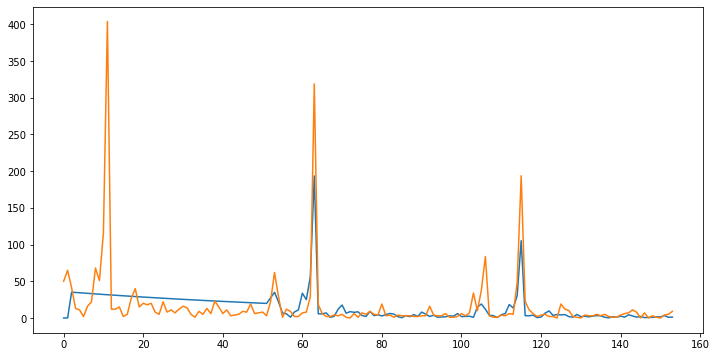

In [42]:
plt.plot(make_ds(data)[0][0][3].y)
plt.plot(make_ds(data)[0][0][2])

In [43]:
ds = make_ds(data)[0]
ds[0][3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_mean,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_median,demand_lag14_wdw7_mean,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_median,demand_lag21_wdw7_mean,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_median,demand_lag28_wdw7_mean,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_median,all_products_demand_lag7_wdw7_mean,all_products_demand_lag7_wdw7_pctl90,all_products_demand_lag7_wdw7_pctl10,...,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR,l,s,b,y
0,50.000000,0.0,0.0,0.0,0.0,35.500000,55.900000,15.1,35.500000,64.000000,64.0,64.0,64.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35.565452,1.000000,0.988396,0.000000
1,65.000000,1.0,500.0,500.0,1.0,37.666667,57.200000,16.4,42.000000,122.500000,169.3,75.7,122.5,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35.152741,1.000000,0.988396,0.000000
2,41.251366,1.0,500.0,500.0,1.0,6.000000,6.000000,6.0,6.000000,105.000000,158.8,65.2,70.0,15.000000,15.0,15.0,15.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,34.744818,1.000000,0.988396,35.152741
3,13.000000,0.0,500.0,500.0,1.0,6.500000,6.900000,6.1,6.500000,44.000000,44.0,44.0,44.0,19.000000,22.2,15.8,19.0,32.000000,32.0,32.0,32.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34.341628,1.000000,0.988396,34.744818
4,11.000000,0.0,500.0,500.0,1.0,7.774135,9.657923,6.2,7.000000,63.500000,79.1,47.9,63.5,17.000000,21.4,13.4,15.0,60.000000,82.4,37.6,60.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,29.000000,29.0,29.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33.943117,1.000000,0.988396,34.341628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

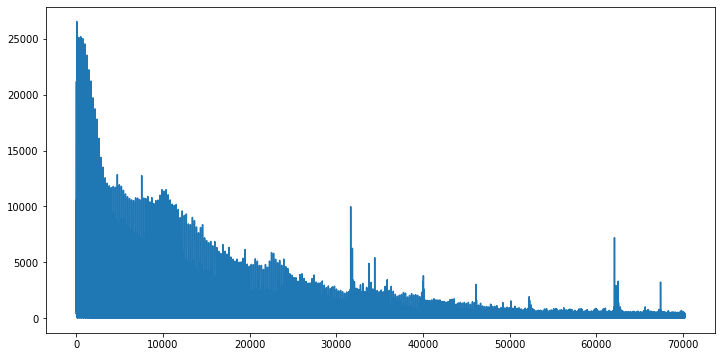

In [44]:
plt.plot(hist)

In [45]:
ds = make_ds(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [46]:
k = 7
smooth = ds[0][k][3].y
val = ds[0][k][1]
y = ds[0][k][2]
print(val.shape,y.shape)

(154, 157) (154, 1)


In [49]:
yhat = [0]*10
n = val.shape[0]
for i in range(10,n):
    yhat.append(model.predict(val[i-10:i].reshape(1, 10, -1))[0][-1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



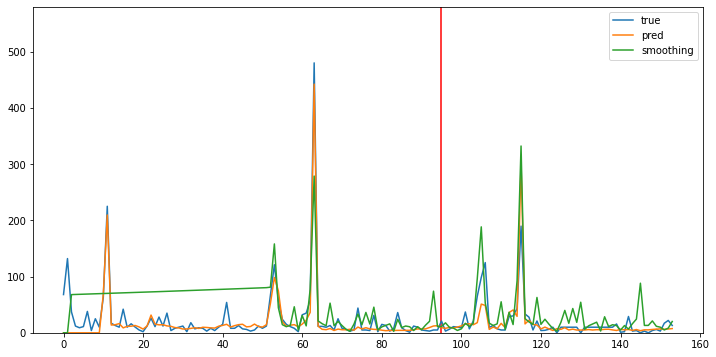

In [50]:
plt.plot(y, label='true')
plt.plot(yhat,label='pred')
plt.plot(smooth,label='smoothing')
plt.vlines(TRAIN_SIZE, 0, 1000, color='red')
plt.ylim(0, y.max()+100)
plt.legend()

In [72]:
test = test.drop(['demand'], axis=1)

In [73]:
# для предсказания нужны:
# l, b за прошлый период
# s за m периодов назад
# y_hat за текущий период
def compute_components_test(n, X_train, m=52):
    alpha = beta = gamma = 0.0005
    l = np.zeros(n+1)
    b = np.zeros(n+1)
    s = np.zeros(n+1)
    y_hat = np.zeros(n+1)
    known_len = X_train.shape[0]
    l[0] = sum(X_train[0:known_len:m]) / (known_len//m + 1) + 0.001
    if n < m:
        l[0] = 1
    for i in range(min(m, n)):
        s[i] = X_train[i]/l[0]
    if 2*m < n:
        #print(X[m:2*m].sum(), X[0:m].sum())
        b[0] = np.exp(1/m*(np.log(X_train[m:2*m].sum() + 0.001) - np.log(X_train[0:m].sum() + 0.001)))
    else:
        b[0] = 1
    for t in range(1, n):
        l[t] = alpha*y_hat[t]
        if (t >= m):
            l[t] /= (s[t-m] + 0.01)
            s[t] = gamma*y_hat[t]/(l[t-1]*b[t-1]) + (1 - gamma)*s[t-m]
        l[t] += (1 - alpha)*l[t-1]*b[t-1]
        b[t] = beta*l[t]/(l[t-1] + 0.001) + (1-beta)*b[t-1]
        y_hat[t+1] = l[t]*b[t]
        if (t - m + 1 >= 0):
            y_hat[t+1] *= s[t-m+1]
    
    return l, b, s, y_hat

In [74]:
def add_components_test(data, data_train):
    products = data.product_rk
    stores = data.store_location_rk
    data['l'] = 0
    data['s'] = 1
    data['b'] = 0
    data['y'] = 0

    for prod in products.unique():
        for store in stores.unique():
            X_curr = data[(data.product_rk == prod) & (data.store_location_rk == store)]
            X_train = train[(train.product_rk == prod) & (train.store_location_rk == store) & ~train.demand.isna()]
            m = 52
            #n = X_curr.demand.shape[0]
            l, b, s, y_hat = compute_components_test(X_curr.shape[0], X_train.demand.to_numpy())
            #print(X_curr.columns)
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store), 'y'] = y_hat[:-1]
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store), 'l'] = l[1:]
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store), 'b'] = b[1:]
            s = [1]*m + list(s)
            data.loc[(data.product_rk == prod) & (data.store_location_rk == store), 's'] = s[:-m-1]

In [75]:
for replace_name in test.columns:
    test[replace_name] = test[replace_name].fillna(0.0)

In [76]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

def split_test(ds, scaler):
    x = scaler.fit_transform(ds.drop(['product_rk','store_location_rk','period_start_dt', 'Unnamed: 0'],axis=1))
    return x, ds
def make_ds_test(dataset, data_train):
    g = dataset.groupby(['product_rk','store_location_rk'])
    gg = np.array(g)[:,1]
    scalers = []
    for i in range(gg.shape[0]):
        ds = gg[i]
        scalers.append(MinMaxScaler(feature_range=(0, 1)))
        add_components_test(ds, data_train)
        ds.reset_index(inplace=True)
    return [split_test(x, scalers[-1]) for x in gg], scalers

len(make_ds_test(test, train)[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



240

In [77]:
ds_test = make_ds_test(test, data)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [78]:
train[(train.product_rk == 40369) & (train.store_location_rk == 380)]

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1873,40369,380,2016-12-19,39.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,4.455555,3.033333,0.0,0.0,3.000000,3.0,0.0,0.0,10.600000,10.000000,0.0,0.0,11.166667,12.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1878,40369,380,2016-12-26,80.000000,1.0,500.0,500.0,1.0,0.000000,0.000000,2.500000,2.500000,0.0,0.0,11.666667,10.0,0.0,0.0,11.500000,12.500000,0.0,0.0,16.600000,17.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1883,40369,380,2017-01-02,39.142077,1.0,500.0,500.0,1.0,7.000000,7.000000,7.000000,7.000000,0.0,0.0,13.000000,13.0,0.0,0.0,16.333333,17.000000,0.0,0.0,9.000000,7.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1888,40369,380,2017-01-09,6.000000,0.0,500.0,500.0,1.0,24.100000,8.900000,16.500000,16.500000,33.0,33.0,33.000000,33.0,0.0,0.0,7.000000,7.000000,0.0,0.0,5.091666,5.016667,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1893,40369,380,2017-01-16,22.000000,0.0,500.0,500.0,1.0,24.326776,9.126776,16.877960,17.633880,108.6,41.4,75.000000,75.0,0.0,0.0,3.033333,3.033333,0.0,0.0,3.000000,3.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [79]:
ds_test[0][1]

,Unnamed: 0,product_rk,store_location_rk,period_start_dt,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,...,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR,l,s,b,y
0,908,40369,317,2019-12-02,0.0,500.0,500.0,1.0,6.033333,2.38,4.138095,3.966667,5.4,0.0,2.285714,2.0,3.8,0.0,2.142857,3.0,5.8,0.0,3.000000,3.0,6.824590,0.0,3.648712,4.0,3.5,2.8,3.071429,3.0,6.0,1.8,4.000000,4.5,5.8,2.1,4.101874,4.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999500,1,0.999999,0.000000
1,914,40369,317,2019-12-09,0.0,500.0,500.0,1.0,3.966667,2.38,3.400000,3.966667,5.4,0.6,2.857143,2.0,3.8,0.0,2.000000,2.0,5.8,0.0,3.000000,3.0,6.824590,0.0,3.791569,4.0,3.2,2.8,3.000000,3.0,4.7,1.8,3.428571,3.5,7.2,2.1,4.601874,4.713115,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999499,1,0.999999,0.000000
2,920,40369,317,2019-12-16,0.0,500.0,500.0,1.0,0.000000,0.00,3.966667,3.966667,5.4,0.6,2.857143,2.0,4.4,0.6,2.571429,3.0,5.8,0.0,3.285714,4.0,6.824590,0.0,3.577283,4.0,3.7,2.8,3.142857,3.0,4.7,1.8,3.214286,3.5,7.2,2.1,4.571429,4.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999498,1,0.999998,0.999499
3,926,40369,317,2019-12-23,0.0,500.0,500.0,1.0,0.000000,0.00,3.966667,3.966667,0.0,0.0,3.333333,3.0,4.4,1.2,2.857143,3.0,6.4,1.2,4.142857,5.0,6.824590,0.0,3.434426,3.5,4.2,2.8,3.357143,3.0,4.1,1.8,3.000000,3.0,7.2,2.1,4.571429,4.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.999496,1,0.999998,0.999498
4,932,40369,317,2019-12-30,0.0,500.0,500.0,1.0,0.000000,0.00,3.966667,3.966667,0.0,0.0,3.600000,4.0,0.0,0.0,3.333333,3.0,6.0,1.2,4.000000,5.0,4.816393,0.0,2.791569,3.5,5.9,2.8,4.071429,3.5,4.1,3.0,3.428571,3.0,7.2,0.0,4.071429,4.500000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,1,0.000000,0.999496


In [80]:
test

,product_rk,store_location_rk,period_start_dt,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,all_products_demand_lag7_wdw7_pctl90,...,store_location_rk_517,store_location_rk_525,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
908,40369,317,2019-12-02,0.0,500.00,500.0,1.0,6.033333,2.38,4.138095,3.966667,5.400000,0.0,2.285714,2.000000,3.800000,0.0,2.142857,3.000000,5.80,0.0,3.000000,3.000000,6.824590,0.0,3.648712,4.0,3.500000,2.800000,3.071429,3.0,6.0,1.8,4.000000,4.5,5.8,2.1,4.101874,4.5,6.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
909,40370,317,2019-12-02,0.0,1000.00,1000.0,1.0,6.600000,0.00,3.142857,3.000000,6.033333,0.0,3.571429,3.966667,3.200000,0.0,1.428571,1.000000,4.20,0.0,2.285714,3.000000,14.600000,0.0,8.785714,10.5,10.500000,8.600000,9.714286,10.0,13.6,5.7,9.928571,10.5,12.2,5.1,9.000000,10.5,6.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
910,40372,317,2019-12-02,0.0,2000.00,2000.0,1.0,16.000000,3.00,10.142857,11.000000,5.800000,0.0,2.857143,3.000000,6.033333,0.0,3.290476,3.966667,3.20,0.0,1.142857,0.000000,7.000000,0.0,4.500000,6.0,5.000000,4.500000,4.857143,5.0,7.1,3.0,5.428571,6.0,6.2,2.4,4.357143,5.0,6.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
911,40373,317,2019-12-02,0.0,3000.00,3000.0,1.0,6.000000,1.20,4.000000,5.000000,14.000000,3.0,8.714286,9.000000,5.200000,0.0,2.142857,1.000000,9.88,0.0,4.295238,3.966667,5.000000,0.0,3.071429,4.0,5.000000,3.600000,4.142857,4.0,5.2,1.8,3.500000,4.0,4.0,1.8,2.928571,3.0,6.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
912,46272,317,2019-12-02,1.0,284.29,199.0,1.0,4.400000,1.20,2.857143,3.000000,6.400000,1.2,4.142857,5.000000,14.000000,0.0,7.571429,9.000000,7.40,0.0,2.714286,1.000000,2.000000,0.0,1.285714,2.0,3.500000,1.500000,2.500000,2.5,5.7,2.3,4.357143,5.0,4.0,1.5,2.642857,2.5,6.1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [81]:
add_components(data)
_ = 0
for ts in ds_test:
    print(_)
    _ += 1
    x = ts[0]
    ds = ts[1]
    y_hat = []
    product = list(ds['product_rk'])[0]
    store = list(ds['store_location_rk'])[0]
    train_last = data[(data.product_rk == product) & (data.store_location_rk == store)][-10:].drop(['product_rk','store_location_rk', 'demand'], axis=1).values
    x = np.vstack((train_last, x))
    for i in range(10, x.shape[0]):
        id = ds.loc[i-10,'Unnamed: 0']
        test.loc[id, 'demand'] = model.predict(x[i-10:i].reshape(1, 10, -1))[0][-1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


In [82]:
test['predicted'] = test['demand']

In [83]:
test[['predicted']].to_csv('prediction.csv')

In [ ]:
sample = pd.read_csv(PATH + '/sample_submission.csv')
sample

,id,predicted
0,908,0
1,909,0
2,910,0
3,911,0
4,912,0
...,...,...
1195,35537,0
1196,35538,0
1197,35539,0
1198,35540,0


In [ ]:
data_test.loc[sample.id.values]

,product_rk,store_location_rk,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,all_products_demand_lag7_wdw7_mean,...,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR,store_location_rk_309,predicted
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
908,40369,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
909,40370,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
910,40372,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
911,40373,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
912,46272,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35537,40370,1380,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0
35538,40372,1380,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
data_test

,id,product_rk,store_location_rk,demand,PROMO1_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,AUTORIZATION_FLAG,demand_lag7_wdw7_mean,demand_lag7_wdw7_median,demand_lag7_wdw7_pctl90,demand_lag7_wdw7_pctl10,demand_lag14_wdw7_mean,demand_lag14_wdw7_median,demand_lag14_wdw7_pctl90,demand_lag14_wdw7_pctl10,demand_lag21_wdw7_mean,demand_lag21_wdw7_median,demand_lag21_wdw7_pctl90,demand_lag21_wdw7_pctl10,demand_lag28_wdw7_mean,demand_lag28_wdw7_median,demand_lag28_wdw7_pctl90,demand_lag28_wdw7_pctl10,all_stores_demand_lag7_wdw7_mean,all_stores_demand_lag7_wdw7_median,all_stores_demand_lag7_wdw7_pctl90,all_stores_demand_lag7_wdw7_pctl10,all_stores_demand_lag14_wdw7_mean,all_stores_demand_lag14_wdw7_median,all_stores_demand_lag14_wdw7_pctl90,all_stores_demand_lag14_wdw7_pctl10,all_stores_demand_lag21_wdw7_mean,all_stores_demand_lag21_wdw7_median,all_stores_demand_lag21_wdw7_pctl90,all_stores_demand_lag21_wdw7_pctl10,all_stores_demand_lag28_wdw7_mean,all_stores_demand_lag28_wdw7_median,all_stores_demand_lag28_wdw7_pctl90,all_stores_demand_lag28_wdw7_pctl10,...,store_location_rk_533,store_location_rk_535,store_location_rk_540,store_location_rk_555,store_location_rk_557,store_location_rk_562,store_location_rk_637,store_location_rk_644,store_location_rk_657,store_location_rk_764,store_location_rk_798,store_location_rk_862,store_location_rk_866,store_location_rk_874,store_location_rk_1005,store_location_rk_1034,store_location_rk_1079,store_location_rk_1080,store_location_rk_1143,store_location_rk_1162,store_location_rk_1173,store_location_rk_1185,store_location_rk_1191,store_location_rk_1202,store_location_rk_1203,store_location_rk_1281,store_location_rk_1316,store_location_rk_1326,store_location_rk_1328,store_location_rk_1347,store_location_rk_1363,store_location_rk_1380,flag_14FEB,flag_23FEB,flag_8MAR,flag_9MAY,flag_1SEP,flag_NEW_YEAR,store_location_rk_309,predicted
0,908,40369,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
1,909,40370,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
2,910,40372,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
3,911,40373,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
4,912,46272,317,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,35543,40370,1380,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1400,35544,40372,1380,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0
1401,35545,40373,1380,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0